# 무신사 스냅 이미지를 이용한 패션 스타일 분류

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/스타일

/content/drive/MyDrive/스타일


In [ ]:
ls

포멀/  댄디/  스포츠/  스트릿/  걸리시/  캐주얼/  로맨틱/  output/


In [16]:
# 클래스 이름(스타일 종류)
class_names = ['걸리시', '댄디', '로맨틱', '스트릿', '스포츠',  '캐주얼', '포멀']

걸리시 / 1897 / 12.606%
댄디 / 1838 / 12.214%
로맨틱 / 847 / 5.629%
스트릿 / 3846 / 25.558%
스포츠 / 869 / 5.775%
캐주얼 / 3796 / 25.226%
포멀 / 1955 / 12.992%


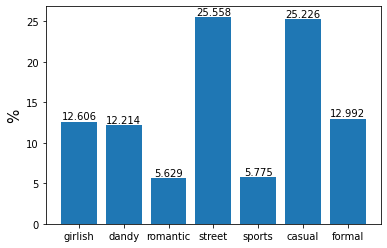

In [ ]:
# 스타일별 이미지 개수 비율(%)
style_count = []
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/스타일", folder_name)
    count = 0
    for fname in os.listdir(folder_path):                                # ex) 스타일/댄디_100.jpg
        count += 1
    style_count.append(count)
  
style_ratio = list(map(lambda x : round(x / sum(style_count) * 100, 3), style_count))

# 시각화
x = np.arange(7)
plt.bar(x, style_ratio)
plt.xticks(x,["girlish", 'dandy', 'romantic', 'street', 'sports', 'casual', 'formal'])
plt.ylabel('%', fontsize=15)
for i, v in enumerate(x):
    plt.text(v, style_ratio[i], style_ratio[i], fontsize = 10, color='black',
             horizontalalignment='center', verticalalignment='bottom') 
    print(f"{class_names[i]} / {style_count[i]} / {style_ratio[i]}%")
plt.show()

In [ ]:
!pip install split-folders

In [ ]:
# train / test 파일 나누기
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/스타일", output="output", seed=2, ratio=(0.75, 0.15,  0.1))

In [17]:
# train / val / test 데이터
train_path = '/content/drive/MyDrive/스타일/output/train'
val_path = '/content/drive/MyDrive/스타일/output/val'
test_path = '/content/drive/MyDrive/스타일/output/test'

In [18]:
batch_size = 32
image_size = (224, 224)

In [19]:
seed = tf.random.set_seed(2)

# train / val / test 데이터셋
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode="categorical",
    class_names=class_names,
    shuffle=True,
    image_size=image_size,
    seed=seed,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    label_mode="categorical",
    class_names=class_names,
    shuffle=True,
    image_size=image_size,
    seed=seed,
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode="categorical",
    class_names=class_names,
    shuffle=True,
    image_size=image_size,
    seed=seed,
    batch_size=batch_size)

Found 15794 files belonging to 7 classes.
Found 2254 files belonging to 7 classes.
Found 1510 files belonging to 7 classes.


In [20]:
# 데이터를 일괄 처리하고 캐싱 및 프리페치를 사용하여 로딩 속도를 최적화

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [ ]:
# JPEG파일이 아닌 이미지 파일 확인

num_skipped = 0
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/스타일", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)                                # 스타일/캐주얼_1.jpg
        try:
            fobj = open(fpath, "rb")
            is_JPEG = tf.compat.as_bytes("jpeg") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_JPEG:
            num_skipped += 1

print(f"{num_skipped} images")

0 images


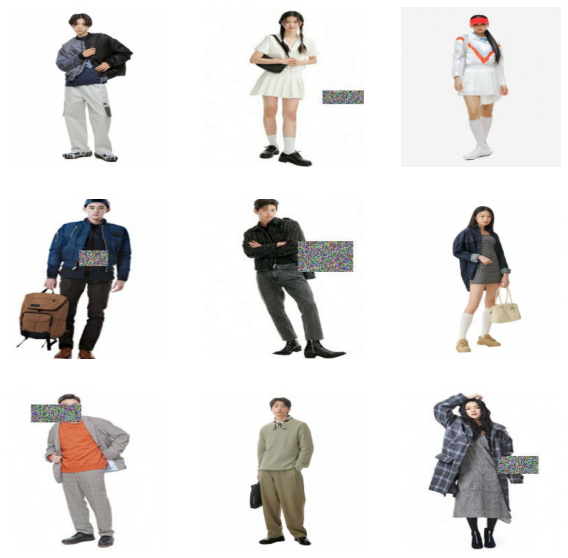

In [ ]:
# 이미지 예시
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### 이미지 데이터 수 증가

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

def image_augmentation(style, count):
  # train 데이터셋만 증강
  img = Augmentor.Pipeline(f'/content/drive/MyDrive/스타일/output/train/{style}')

  # 좌우 반전
  img.flip_left_right(probability=1.0)                             
                                                                              
  #회전
  img.rotate(probability=1, max_left_rotation=10, max_right_rotation=10)

  #랜덤 지우기
  img.random_erasing(probability=0.7, rectangle_area=0.3)

  # 증강할 이미지 개수
  img.sample(int(count * 0.3))      # 30% 증강

In [ ]:
# 스타일별로 증강
for style, count in zip(class_names, style_count):
  image_augmentation(style, count)

Initialised with 1422 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/걸리시/output.

Processing <PIL.Image.Image image mode=RGB size=220x330 at 0x7FAF266E5AD0>: 100%|██████████| 569/569 [00:06<00:00, 85.64 Samples/s] 


Initialised with 1378 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/댄디/output.

Processing <PIL.Image.Image image mode=RGB size=235x330 at 0x7FAF265A0B90>: 100%|██████████| 551/551 [00:06<00:00, 89.14 Samples/s]


Initialised with 635 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/로맨틱/output.

Processing <PIL.Image.Image image mode=RGB size=235x330 at 0x7FAFA6D82B90>: 100%|██████████| 254/254 [00:02<00:00, 85.58 Samples/s]


Initialised with 2884 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/스트릿/output.

Processing <PIL.Image.Image image mode=RGB size=220x330 at 0x7FAFA9059050>: 100%|██████████| 1153/1153 [00:13<00:00, 86.82 Samples/s]


Initialised with 651 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/스포츠/output.

Processing <PIL.Image.Image image mode=RGB size=236x330 at 0x7FAFA8A7AAD0>: 100%|██████████| 260/260 [00:02<00:00, 87.38 Samples/s]


Initialised with 2847 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/캐주얼/output.

Processing <PIL.Image.Image image mode=RGB size=235x330 at 0x7FAFA6D6BFD0>: 100%|██████████| 1138/1138 [00:13<00:00, 81.89 Samples/s]


Initialised with 1466 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/포멀/output.

Processing <PIL.Image.Image image mode=RGB size=235x330 at 0x7FAFA8B90650>: 100%|██████████| 586/586 [00:06<00:00, 87.87 Samples/s]


In [ ]:
plus_image = []
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/스타일/output/train/", folder_name, 'output')
    count = 0
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)                                
        count += 1
    plus_image.append(count)

print("원본 데이터수", style_count)
print("추가된 데이터수", plus_image)

원본 데이터수 [1897, 1838, 847, 3846, 869, 3796, 1955]
추가된 데이터수 [569, 551, 254, 1153, 260, 1138, 586]


## 데이터 증강


In [21]:
from tensorflow.keras import Sequential, Input, layers

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

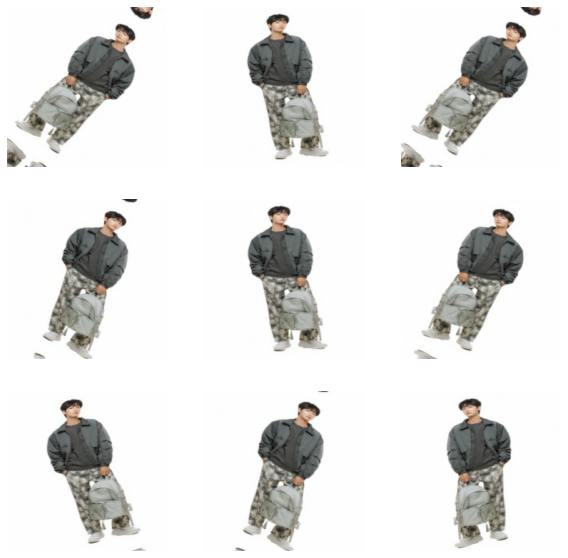

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# 훈련 데이터에 적용
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

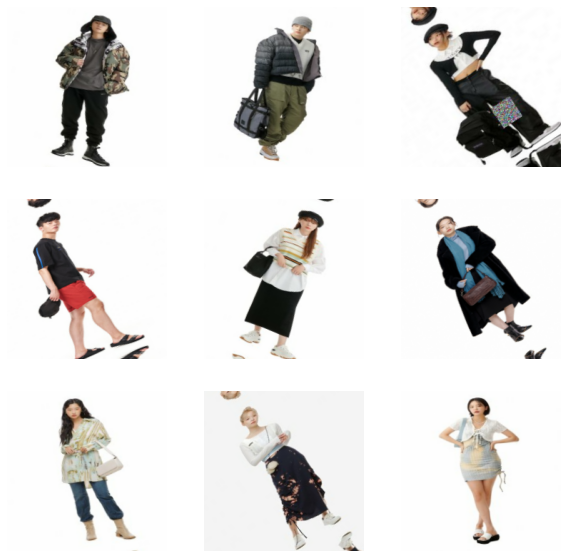

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        plt.axis("off")

## 모델링

In [22]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential

In [23]:
# accuracy 그래프
def acc_graph(history):  
  acc = history.history['accuracy']                                             # loss = history.history['loss']
  val_acc = history.history['val_accuracy']                                     # val_loss = history.history['val_loss']
 
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Train Accuracy')
  plt.plot(val_acc, label='Val Accuracy')
  plt.text(len(acc)-2, val_acc[-1], f'{val_acc[-1]:.4f}')   # 최종 acc
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())+0.05])       # [최소, 최대]
  plt.title('Train and Val Accuracy')

In [24]:
def train_model(model, train_X, val_X, learning_rate, epochs):
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics='accuracy')

  # early stopping 설정
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

  hist = model.fit(train_X, validation_data=val_X, epochs=epochs, callbacks=[early_stop])
  return hist

In [ ]:
# 기본적인 CNN모델
def CNN_model(num_classes=7, input_shape=(224, 224, 3)):
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(layers.experimental.preprocessing.Rescaling(1./255))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPool2D())
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPool2D())
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax')) 

  return model

CNN_model1 = CNN_model()
CNN_model2 = CNN_model()

In [ ]:
CNN_hist1 = train_model(CNN_model1, train_ds, val_ds, 32, 50)       # 0.4215

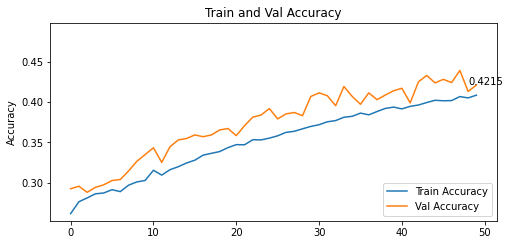

In [ ]:
acc_graph(CNN_hist1)

In [ ]:
CNN_model1.evaluate(test_ds)

48/48 [==============================] - 109s 2s/step - loss: 1.5405 - accuracy: 0.3974


[1.5404845476150513, 0.3973509967327118]

In [ ]:
CNN_hist2 = train_model(CNN_model2, augmented_train_ds, val_ds, 64, 30)   # 증강  0.4246

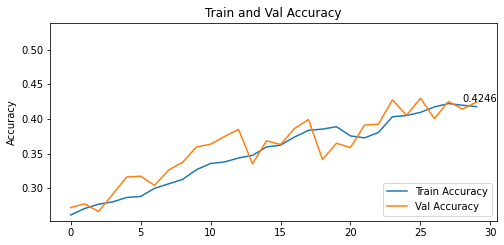

In [ ]:
acc_graph(CNN_hist2)

In [ ]:
CNN_model2.evaluate(test_ds)

24/24 [==============================] - 2s 64ms/step - loss: 1.4816 - accuracy: 0.4272


[1.4816123247146606, 0.4271523058414459]

## ResNet 모델(tensorflow)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# ResNet 모델
def ResNet50_model(num_classes=7, input_shape=(224, 224, 3)):
  # ImageNet으로 학습된 ResNet-50 모델
  # include_top=False 가장 마지막의 classification layer는 포함하지 않는다
  resnet = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
      
  # 불러온 ResNet50 모델의 모든 layer를 freeze(학습 가능하지 않게 설정)
  resnet.trainable=False

  model = Sequential([
                      layers.experimental.preprocessing.Rescaling(1./255),
                      resnet,
                      layers.GlobalAveragePooling2D(),
                      layers.BatchNormalization(),
                      layers.Dense(256, activation='relu'),
                      layers.Dropout(0.2),
                      layers.Dense(num_classes, activation='softmax')
  ])
  
  return model

resnet_model1 = ResNet50_model()  

In [ ]:
resnet_hist1 = train_model(resnet_model1, train_ds, val_ds, 1e-5, 30) 

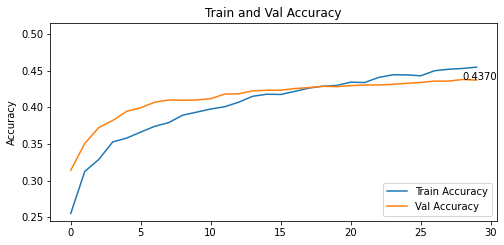

In [ ]:
acc_graph(resnet_hist1)

In [ ]:
resnet_model1.evaluate(test_ds)

48/48 [==============================] - 3s 58ms/step - loss: 1.3867 - accuracy: 0.4291


[1.3867061138153076, 0.42913907766342163]

## EfficientNetB0

In [46]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

def EfficientNetB0_model(num_classes=7, input_shape=(224,224,3), freeze=False):
  # EfficientNet 모델은 1./255 scaling이 포함되어 있음
  inputs = layers.Input(shape=input_shape)                                      

  # ImageNet으로 학습된 EfficientNetB0 모델
  # include_top=False 가장 마지막의 classification layer는 포함하지 않는다
  effi_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)

  # 불러온 EfficientNetB0 모델의 모든 layer를 freeze(학습 가능하지 않게 설정)
  effi_model.trainable=freeze
  
  x = layers.GlobalAveragePooling2D()(effi_model.output)
  # x = layers.Dense(256)(x)
  # x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)                                       
                                                                                
  return model

In [47]:
NUM_CLASSES = 7
INPUT_SHAPE = (224, 224, 3)

In [ ]:
# 모든 layer 학습 동결
effiB0_model1 = EfficientNetB0_model(NUM_CLASSES, INPUT_SHAPE, False)

effi_hist1 = train_model(effiB0_model1, train_ds, val_ds, 1e-4, 30)

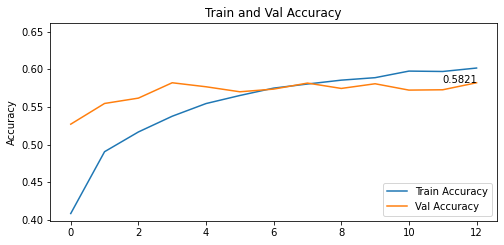

In [ ]:
acc_graph(effi_hist1)

In [ ]:
effiB0_model1.summary()
"""
Total params: 4,384,426
Trainable params: 332,295
Non-trainable params: 4,052,131
"""

In [ ]:
# 특정 데이터 세트에 따라 모든 레이어의 일부만 고정 해제하는 것이 바람직할 수 있다
effiB0_model2 = EfficientNetB0_model(NUM_CLASSES, INPUT_SHAPE, False)

for layer in effiB0_model2.layers[-20:]:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

effi_hist2 = train_model(effiB0_model2, train_ds, val_ds, 1e-4, 30)

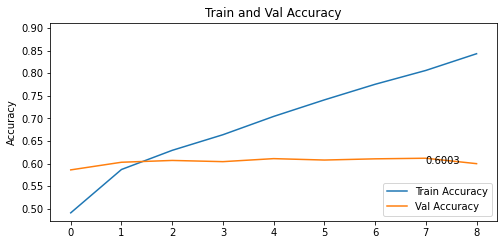

In [28]:
acc_graph(effi_hist2)

In [ ]:
effiB0_model2.summary()
"""
Total params: 4,379,306
Trainable params: 1,451,319
Non-trainable params: 2,927,987
"""

In [ ]:
# freeze를 하지 않고 훈련할때는 learning rate를 아주 작게(1e-5)해야한다
# 과적합 위험이 있으므로 epoch도 적게 한다 -> early stopping
effiB0_model3 = EfficientNetB0_model(NUM_CLASSES, INPUT_SHAPE, False)

for layer in effiB0_model3.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

effi_hist3 = train_model(effiB0_model3, train_ds, val_ds, 1e-5, 30)

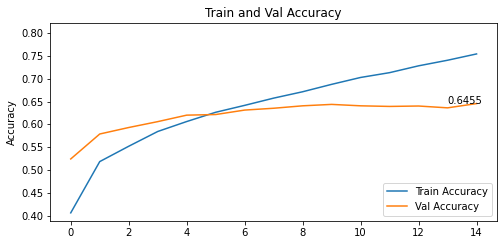

In [ ]:
acc_graph(effi_hist3)   # 0.6455 -> best

In [ ]:
effiB0_model3.summary()
"""
Total params: 4,379,306
Trainable params: 4,295,267
Non-trainable params: 84,039
"""

In [ ]:
effiB0_model3.evaluate(test_ds)

48/48 [==============================] - 121s 2s/step - loss: 0.9827 - accuracy: 0.6318


[0.9827222228050232, 0.6317880749702454]

In [ ]:
# 증강한 데이터셋 -> 성능이 더 떨어짐
effiB0_model4 = EfficientNetB0_model(NUM_CLASSES, INPUT_SHAPE, False)

for layer in effiB0_model4.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

effi_hist4 = train_model(effiB0_model4, augmented_train_ds, val_ds, 1e-5, 30)

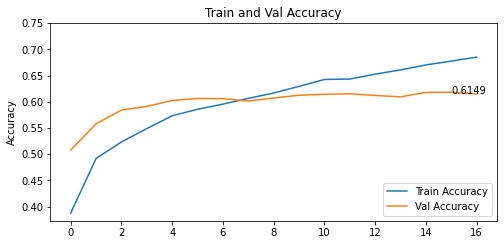

In [ ]:
acc_graph(effi_hist4)

In [ ]:
from keras.models import load_model

# effiB0_model3.save('EfficientNetB0_model.h5')
# final_model = load_model('/content/EfficientNetB0_model.h5')

# EfficientNet (Pytorch)

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.optim import lr_scheduler
import time
import copy
import random

import torch.nn as nn
import torch.optim as optim

In [ ]:
# train / val / test 데이터

image_data = {'train' : datasets.ImageFolder(train_path,
                                             transforms.Compose([
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                 ])),
              'valid' : datasets.ImageFolder(val_path,
                                             transforms.Compose([
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                 ])),
              'test' : datasets.ImageFolder(test_path,
                                            transforms.Compose([
                                                transforms.Resize((224, 224)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                ]))}

In [ ]:
dataloaders = {data : torch.utils.data.DataLoader(image_data[data], 
                                                  batch_size=batch_size, 
                                                  shuffle=True) for data in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_data[x]) for x in ['train', 'valid', 'test']}
print(dataset_sizes)

{'train': 15794, 'val': 2254, 'test': 1510}


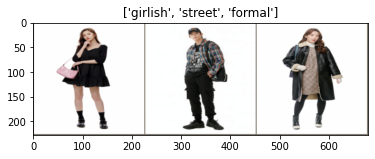

In [ ]:
# 이미지 확인
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num = 3

CLASS = {"0":"girlish", "1":"dandy", "2":"romantic",
         "3":"street", "4":"sports", "5":"casual", "6":"formal"}

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs[:num])

imshow(out, title=[CLASS[str(int(x))] for x in classes[:num]])

In [ ]:
def training_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # train 모드
            else:
                model.eval()   # eval 모드

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 0으로 설정 / zero the parameter gradients
                optimizer.zero_grad()

                # 순전파
                # train일때만 history 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 역전파, 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# seed 설정
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
  
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

# 모델 구조만 가져오기
#model = EfficientNet.from_name('efficientnet-b0')

# 사전 학습된 모델
model_ft = EfficientNet.from_pretrained('efficientnet-b0', num_classes=7)
                                                                                # num_ftrs = model_ft.fc.in_features
                                                                                # model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

Loaded pretrained weights for efficientnet-b0


In [ ]:
model_ft = training_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
train Loss: 0.9002 Acc: 0.6511
val Loss: 0.9607 Acc: 0.6247

Epoch 2/20
train Loss: 0.6985 Acc: 0.7357
val Loss: 0.9457 Acc: 0.6318

Epoch 3/20
train Loss: 0.5178 Acc: 0.8070
val Loss: 0.9700 Acc: 0.6358

Epoch 4/20
train Loss: 0.3702 Acc: 0.8660
val Loss: 1.1695 Acc: 0.6384

Epoch 5/20
train Loss: 0.2650 Acc: 0.9074
val Loss: 1.2927 Acc: 0.6318

Epoch 6/20
train Loss: 0.2043 Acc: 0.9307
val Loss: 1.4481 Acc: 0.6207

Epoch 7/20
train Loss: 0.1433 Acc: 0.9545
val Loss: 1.2491 Acc: 0.6486

Epoch 8/20
train Loss: 0.1181 Acc: 0.9621
val Loss: 1.2616 Acc: 0.6486

Epoch 9/20
train Loss: 0.1121 Acc: 0.9652
val Loss: 1.2804 Acc: 0.6464

Epoch 10/20
train Loss: 0.1033 Acc: 0.9699
val Loss: 1.3168 Acc: 0.6411

Epoch 11/20
train Loss: 0.0957 Acc: 0.9711
val Loss: 1.3220 Acc: 0.6473

Epoch 12/20
train Loss: 0.0939 Acc: 0.9718
val Loss: 1.3540 Acc: 0.6411

Epoch 13/20
train Loss: 0.0901 Acc: 0.9719
val Loss: 1.3538 Acc: 0.6429

Epoch 14/20
train Loss: 0.0849 Acc: 0.9749
val Loss: 1.3565 

# pytorch tutorial

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)